In [46]:
%matplotlib inline

from keras.optimizers import SGD, Adagrad, Adadelta
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import h5py
import numpy as np
import seaborn as sns
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16

In [ ]:
fobia_folder = "./trypophobic/"
normal_folder = "./data_train/reddit_sub_pics/"
resolution_x = 224
resolution_y = 224

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,# rotation_range=20, horizontal_flip=True, 
                                   dim_ordering='th',
                                  zca_whitening=False, featurewise_center=False, featurewise_std_normalization=False)
train_data_generator = train_datagen.flow_from_directory('dane/data_train/',
                                            target_size=(resolution_x, resolution_y),
                                            batch_size=8,
                                            class_mode="categorical",
                                            shuffle = False,
                                            classes=['non-trypophobic','trypophobic'])

test_datagen = ImageDataGenerator(rescale=1./255, dim_ordering='th',
                                 zca_whitening=False, featurewise_center=False, featurewise_std_normalization=False)
test_data_generator = test_datagen.flow_from_directory('dane/data_valid/',
                                            target_size=(resolution_x, resolution_y),
                                            batch_size=8,
                                            class_mode="categorical",
                                            shuffle = False,
                                            classes=['non-trypophobic','trypophobic'])

In [4]:
def VGG_16(weights_path=None, num_of_conv_blocks = 1):
    
    model = Sequential()
    i = 0
    while(True):
        model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
        model.add(Convolution2D(64, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(64, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        
        i+=1
        if(i == num_of_conv_blocks):
            break
        
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(128, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(128, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        
        i+=1
        if(i == num_of_conv_blocks):
            break

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        
        i+=1
        if(i == num_of_conv_blocks):
            break

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        
        i+=1
        if(i == num_of_conv_blocks):
            break

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        
        break

    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
        model.layers[k].trainable = False
    f.close()
    print('Model loaded.')
    
    #model.add(Flatten())
    #model.add(Dense(4096, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(4096, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(1000, activation='softmax'))

    return model

#sgd = "adam"#SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
#Get the pre-trained vgg model
vgg_model = VGG_16('vgg16_weights.h5', 5)

from keras_sequential_ascii import sequential_model_to_ascii_printout
sequential_model_to_ascii_printout(vgg_model)

Model loaded.
      OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

          Input   #####   (3, 224, 224)
  ZeroPadding2D   \|||/ -------------------         0     0.0%
                  #####   (3, 226, 226)
  Convolution2D    \|/  -------------------      1792     0.0%
           relu   #####   (64, 224, 224)
  ZeroPadding2D   \|||/ -------------------         0     0.0%
                  #####   (64, 226, 226)
  Convolution2D    \|/  -------------------     36928     0.3%
           relu   #####   (64, 224, 224)
   MaxPooling2D   YYYYY -------------------         0     0.0%
                  #####   (64, 112, 112)
  ZeroPadding2D   \|||/ -------------------         0     0.0%
                  #####   (64, 114, 114)
  Convolution2D    \|/  -------------------     73856     0.5%
           relu   #####   (128, 112, 112)
  ZeroPadding2D   \|||/ -------------------         0     0.0%
                  #####   (128, 114, 114)
  Convolution2D    \|/  ------------------- 

In [6]:
def predict_generator_status(model, generator, number):
    res = []
    labels = []
    num = 0
    for batch_X, batch_Y in tqdm(generator):
        batch_res = model.predict_on_batch(batch_X)
        for prediction in batch_res:
            res.append(prediction)
        for label in batch_Y:
            labels.append(label)
        num+=generator.batch_size
        
        if num >= number:
            break
    return np.array(res), np.array(labels)

In [7]:
# Calculate bottleneck features of vgg model
bottleneck_features_train = None
train_labels = None
bottleneck_features_validation = None
validation_labels = None

if os.path.isfile("dane/bottleneck_features_train.npy"):
    bottleneck_features_train = np.load(open('dane/bottleneck_features_train.npy', 'rb'))
    train_labels = np.load(open('dane/bottleneck_features_train_labels.npy', 'rb'))
    bottleneck_features_validation = np.load(open('dane/bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.load(open('dane/bottleneck_features_validataion_labels.npy', 'rb'))
else:    
    bottleneck_features_train, train_labels = predict_generator_status(vgg_model, train_data_generator, 1560)
    np.save(open('dane/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    np.save(open('dane/bottleneck_features_train_labels.npy', 'wb'), train_labels)

    bottleneck_features_validation, validation_labels = predict_generator_status(vgg_model, test_data_generator, 320)
    np.save(open('dane/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)
    np.save(open('dane/bottleneck_features_validataion_labels.npy', 'wb'), validation_labels)


In [8]:
untrained = False
top_model = None
if untrained or not os.path.isfile('bottleneck_fc_model.h5'):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
    top_model.add(Dense(512, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(100, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(2, activation='softmax'))

    top_model.compile("adam",#SGD(lr=0.1, decay=1e-9, momentum=0.1, nesterov=True),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = top_model.fit(bottleneck_features_train, train_labels,
              nb_epoch=10, batch_size=8,
              validation_data=(bottleneck_features_validation, validation_labels), verbose=2,
                callbacks=[ModelCheckpoint(save_best_only=True, filepath="dane/top_vgg16_4_weights.{epoch:02d}-{val_loss:.2f}.hdf5")])
    top_model.save('bottleneck_fc_model.h5')
else:
    top_model = load_model('bottleneck_fc_model.h5')

In [9]:
#unlock the last conv layer
for layer in vgg_model.layers[-5:-1]:
    layer.trainable = True
#add the bottom layer
vgg_model.add(top_model)

In [10]:
#new generators for tuning vgg
train_datagen_vgg = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True, 
                                   dim_ordering='th',
                                  zca_whitening=False, featurewise_center=False, featurewise_std_normalization=False)
train_data_generator_vgg = train_datagen.flow_from_directory('dane/data_train/',
                                            target_size=(resolution_x, resolution_y),
                                            batch_size=8,
                                            class_mode="categorical",
                                            shuffle = True,
                                            classes=['non-trypophobic','trypophobic'])

test_datagen_vgg = ImageDataGenerator(rescale=1./255, dim_ordering='th',
                                 zca_whitening=False, featurewise_center=False, featurewise_std_normalization=False)
test_data_generator_vgg = test_datagen.flow_from_directory('dane/data_valid/',
                                            target_size=(resolution_x, resolution_y),
                                            batch_size=8,
                                            class_mode="categorical",
                                            shuffle = True,
                                            classes=['non-trypophobic','trypophobic'])

Found 1560 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [12]:
if not os.path.isfile('FAJNA_SIEC.h5'):
    vgg_model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=1e-5, momentum=0.9),
                  metrics=['accuracy'])
    vgg_model.fit_generator(nb_val_samples=320, samples_per_epoch=1560, nb_epoch=2,
                        generator=train_data_generator_vgg,
                        validation_data=test_data_generator_vgg)
    vgg_model.save_weights("FAJNA_SIEC.h5")
else:
    vgg_model.load_weights("FAJNA_SIEC.h5")

In [60]:
#vgg_model.predict_generator(test_data_generator_vgg, 320)

num_cor = 0
num_total = 0

failed_images_try = []
failed_images_norm = []

for batch_X, batch_Y in test_data_generator_vgg:
    pre_Y = vgg_model.predict_on_batch(batch_X)
    i = 0
    for a,b in zip(pre_Y, batch_Y):
        if (a[0]>a[1] and b[0]==1 ) or (a[0]<=a[1] and b[1]==1 ):
            num_cor+=1
        else:
            if b[1]==1:
                failed_images_try.append(batch_X[i])
            else:
                failed_images_norm.append(batch_X[i])
        num_total+=1
        i+=1
    if(num_total >= 320):
        break
print ("Accuracy %.02f"%(float(num_cor)/num_total*100))

Accuracy 88.44


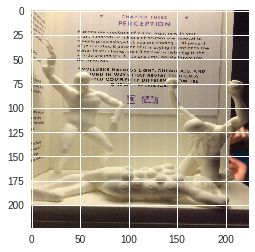

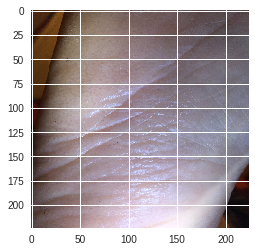

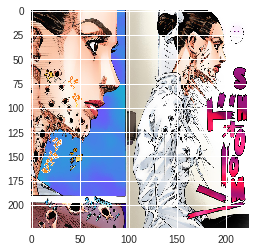

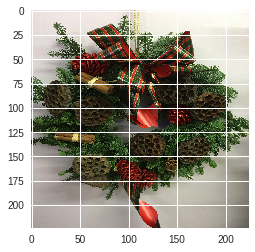

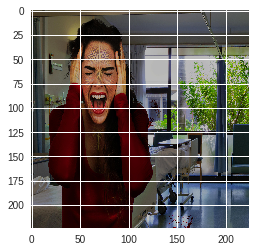

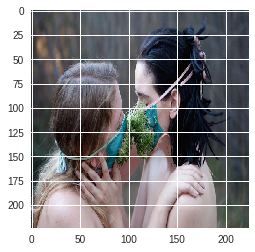

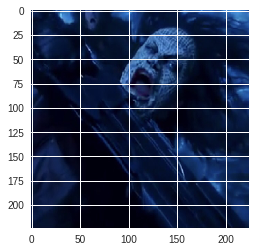

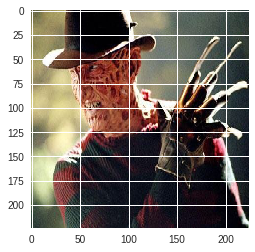

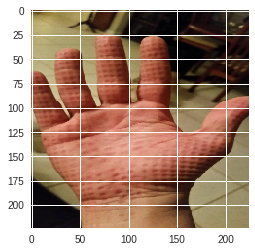

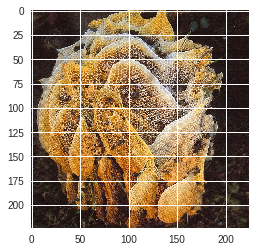

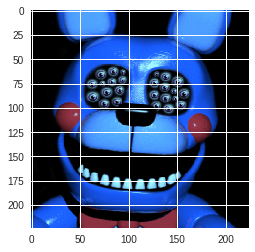

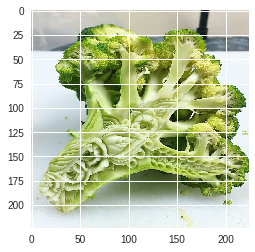

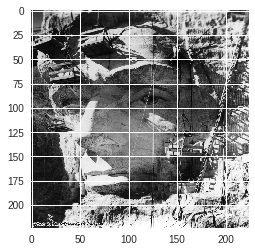

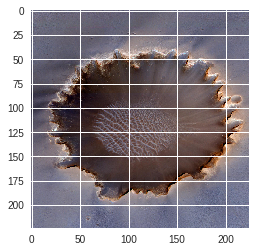

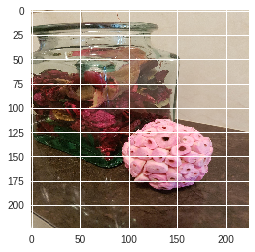

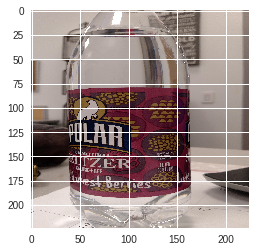

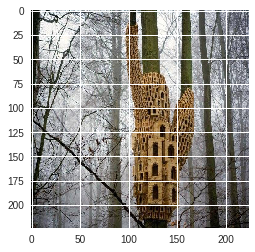

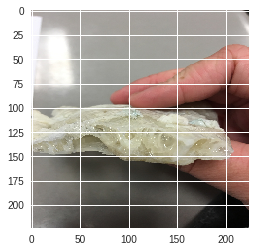

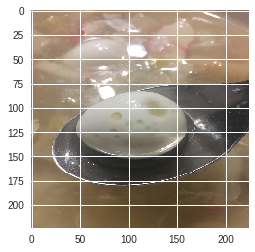

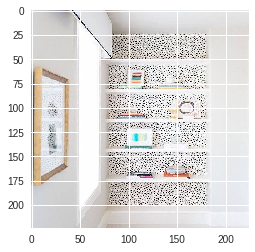

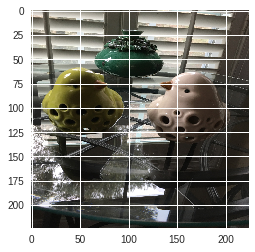

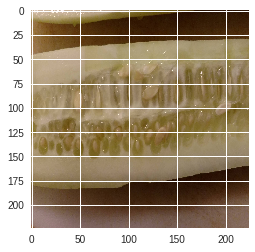

In [99]:
for img in failed_images_try:
    plt.imshow(np.rollaxis(np.rollaxis(img, -1),-1))
    plt.show()

In [ ]:
model.save("pretraining.h5")

In [ ]:
weights = model.layers[0].W.get_value(borrow=True).reshape(8,10,10,3)
print (weights.shape)
fig, axes = plt.subplots(2,8, sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = (10,5)
for i,w in enumerate(weights):
    axes[int(i/8)][int(i%8)].imshow(w)
    if(i == 31):
        break
plt.show()

In [ ]:
np.random.seed(4)
sample_image = X_test[np.random.randint(0, len(X_test))]
plt.imshow(sample_image.reshape(resolution_x, resolution_y, 3))
plt.show()

In [ ]:
convout1_f = theano.function(model.inputs, [model.layers[1].output])
sample_outs = convout1_f([sample_image.astype(np.float32)])[0][0]

fig, axes = plt.subplots(4,8, sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = (10, 5)
for i,w in enumerate(sample_outs):
    axes[int(i/8)][int(i%8)].imshow(w, cmap="gray")
    #sns.heatmap(w)
    #plt.show()
plt.show()